# 1. Introduction

Name : Erlangga Jayadipraja

Batch : SBY - 002

Dataset : [Vehicle Damage Insurance Verification](https://www.kaggle.com/datasets/sudhanshu2198/ripik-hackfest)

Deployment : [HuggingFace](https://huggingface.co/spaces/ejayadipraja/P2GC7)

Objective : Create a model to classify vehicle damage image for insurance verification


|**Label**|**Description**|
|:---:|:---:|
|1|Crack|
|2|Scratch|
|3|Tire Flat|
|4|Dent|
|5|Glass Shatter|
|6|Lamp Broken|

# 2. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout ,BatchNormalization
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')


# 3. Data Loading

In [2]:
# Read Csv 
df = pd.read_csv('D:/Hacktiv8/Phase_2/GC7/train/train/train.csv')

In [3]:
df.head()

,image_id,filename,label
0,1,1.jpg,2
1,2,2.jpg,4
2,3,3.jpg,2
3,4,4.jpg,3
4,5,5.jpg,5


In [4]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  7200 non-null   int64 
 1   filename  7200 non-null   object
 2   label     7200 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 168.9+ KB


In [5]:
# Class label
image_label = {
    1 : 'crack',
    2 : 'scratch',
    3 : 'tire flat',
    4 : 'dent',
    5 : 'glass shatter',
    6 : 'lamp broke'
}

In [6]:
# Change numeric label with name label
df['label'].replace(image_label, inplace=True)

# 4. Exploratory Data Analysis (EDA)

<BarContainer object of 6 artists>

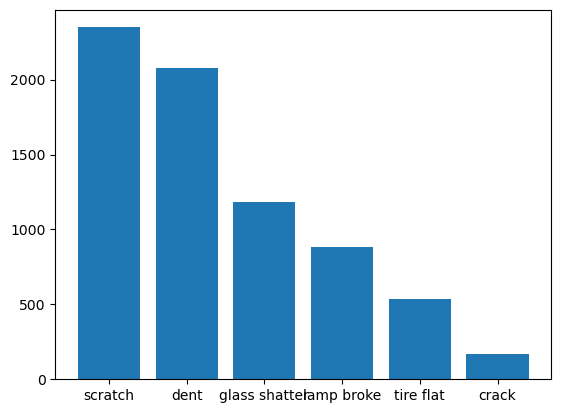

In [7]:
label=df['label'].value_counts()
plt.bar(label.index,label.values)

Class distribution of the dataset , it can be seen that the distribution is very unbalanced because there is one class that is very many and there are very frew classes so that can cause the model not good enough when learning the data so that can make the model training results are not to optimal.

# 5. Feature Engineering

In [8]:
# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=10)

# Split test set into test and validation sets
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=10)

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

# Train
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory='D:/Hacktiv8/Phase_2/GC7/train/train/images/',
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=126,
    shuffle=False
)

# Test
test_gen = test_datagen.flow_from_dataframe(
    test_df,
    directory='D:/Hacktiv8/Phase_2/GC7/train/train/images/',
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=126,
    shuffle=False
)

# Validation
val_gen = val_datagen.flow_from_dataframe(
    val_df,
    directory='D:/Hacktiv8/Phase_2/GC7/train/train/images/',
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=126,
    shuffle=False
)

Found 5040 validated image filenames belonging to 6 classes.
Found 1080 validated image filenames belonging to 6 classes.
Found 1080 validated image filenames belonging to 6 classes.


Split the data into 3, train with 70% data, test and validation with 15% data each.

In [9]:
# Class
print(train_gen.class_indices)
print(test_gen.class_indices)
print(val_gen.class_indices)

{'crack': 0, 'dent': 1, 'glass shatter': 2, 'lamp broke': 3, 'scratch': 4, 'tire flat': 5}
{'crack': 0, 'dent': 1, 'glass shatter': 2, 'lamp broke': 3, 'scratch': 4, 'tire flat': 5}
{'crack': 0, 'dent': 1, 'glass shatter': 2, 'lamp broke': 3, 'scratch': 4, 'tire flat': 5}


Data has been separated with the label

**Visualize Data**

In [10]:
np.random.randint(len(train_gen.next()[0]), size=16)

array([ 98,  92,   4,  32,  69, 100, 100,  77, 112, 119,  42,  81,  75,
        70,  71,  75])

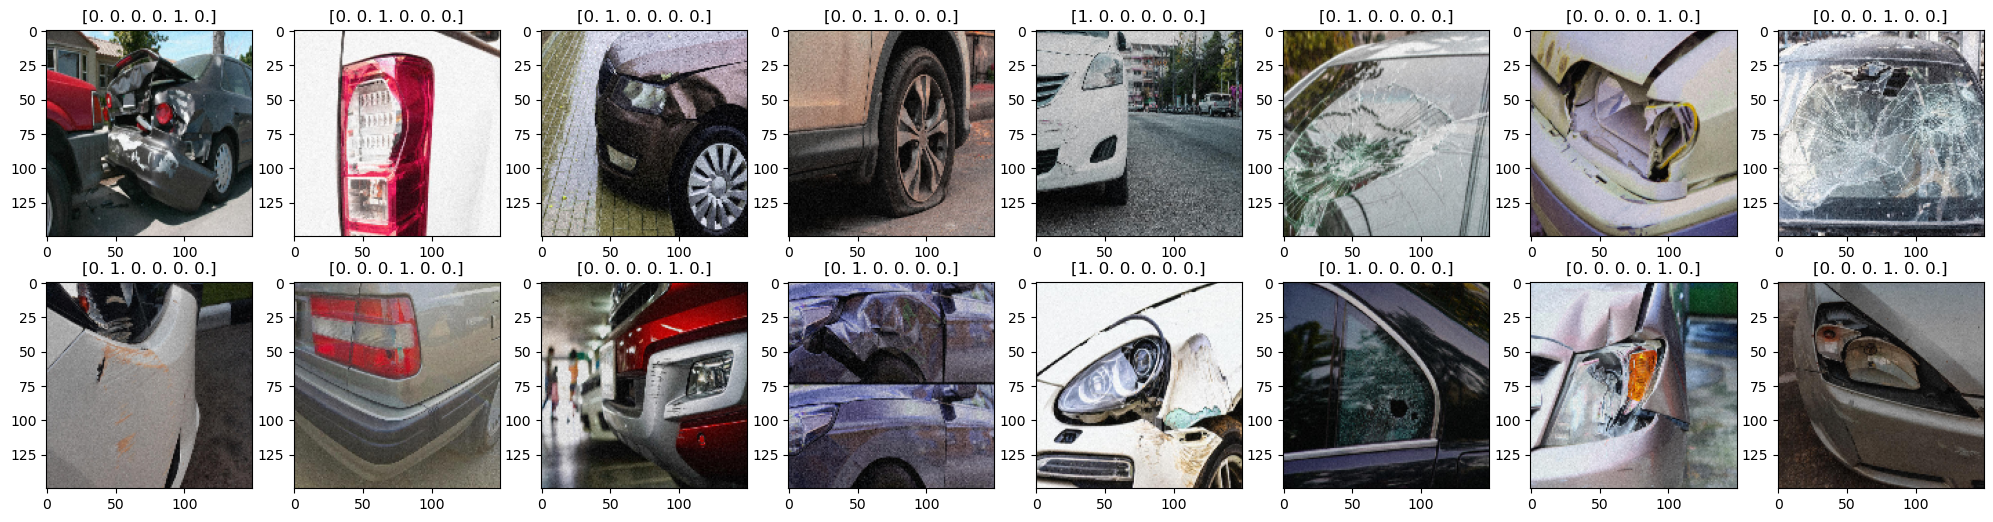

In [11]:
fig,ax = plt.subplots(nrows=2,ncols=8,figsize=(25,6))
n = 0
idx = np.random.randint(len(train_gen.next()[0]), size=16)
for i in range(2):
  for j in range(8):
    img = train_gen.next()[0][idx[n]]
    ax[i][j].imshow(img)
    ax[i][j].set_title(train_gen.next()[1][idx[n]])
    n+=1

- `Crack` means the car is completly destroyed.
- `Scratch` means there are only scratches on the car.
- `Tire Flat` meeans one or all tires are flat.
- `Dent` means there are dents on the car body.
- `Glass Shatter` means that the glass in car is broken.
- `Lamp Broken` means there is a broken car lamp

# 6 Base Model

## 6.1 - Model Definition

In [12]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [13]:
# Build the model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

## 6.2 - Model Training

In [14]:
# Train the model
history = model.fit(train_gen, epochs=20, validation_data=val_gen)

Epoch 1/20


40/40 [==============================] - 58s 1s/step - loss: 2.0966 - accuracy: 0.2990 - val_loss: 1.5236 - val_accuracy: 0.3694
Epoch 2/20
40/40 [==============================] - 57s 1s/step - loss: 1.4096 - accuracy: 0.3996 - val_loss: 1.3086 - val_accuracy: 0.4704
Epoch 3/20
40/40 [==============================] - 58s 1s/step - loss: 1.2423 - accuracy: 0.4774 - val_loss: 1.1918 - val_accuracy: 0.5380
Epoch 4/20
40/40 [==============================] - 57s 1s/step - loss: 1.1311 - accuracy: 0.5292 - val_loss: 1.1741 - val_accuracy: 0.5130
Epoch 5/20
40/40 [==============================] - 55s 1s/step - loss: 1.0235 - accuracy: 0.5829 - val_loss: 1.1033 - val_accuracy: 0.5519
Epoch 6/20
40/40 [==============================] - 56s 1s/step - loss: 0.9166 - accuracy: 0.6294 - val_loss: 1.0649 - val_accuracy: 0.5759
Epoch 7/20
40/40 [==============================] - 58s 1s/step - loss: 0.7725 - accuracy: 0.6938 - val_loss: 0.9464 - val_accuracy: 0.6407
Epoch 8/20
40/40 [

## 6.3 - Model Evaluation

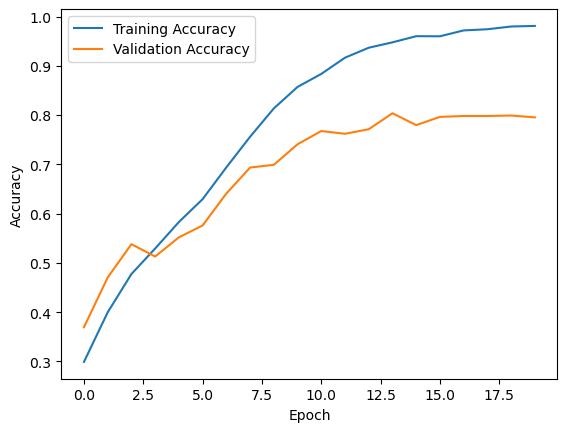

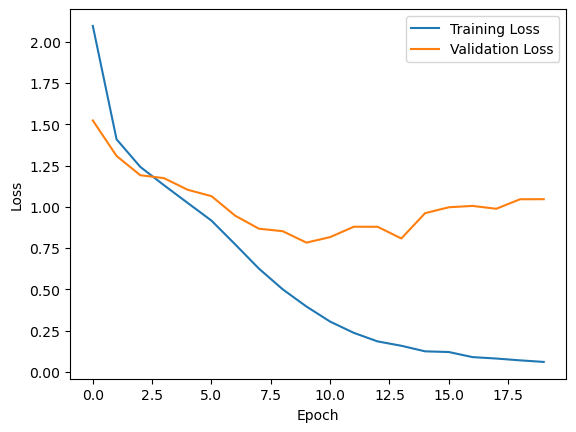

In [15]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The result of the baseline model are still overfit with `Train` results of 0.98 with `Validation` result of 0.79 and `Loss` which also shows the model does not learn well.

# 7. Model Improvement

# 7.1 - Model Definiton

In [16]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [17]:
# Build the improved model
improved_model = Sequential()
improved_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
improved_model.add(BatchNormalization())
improved_model.add(MaxPooling2D(2, 2))
improved_model.add(Conv2D(64, (3, 3), activation='relu'))
improved_model.add(BatchNormalization())
improved_model.add(MaxPooling2D(2, 2))
improved_model.add(Conv2D(128, (3, 3), activation='relu'))
improved_model.add(BatchNormalization())
improved_model.add(MaxPooling2D(2, 2))
improved_model.add(Flatten())
improved_model.add(Dense(512, activation='relu'))
improved_model.add(BatchNormalization())
improved_model.add(Dropout(0.5))
improved_model.add(Dense(6, activation='softmax'))

# Compile the model
improved_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callback
checkpoint = ModelCheckpoint(filepath='best_model.h5',monitor='val_loss',save_best_only=True, mode='max',verbose=1)

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

## 7.2 - Model Training

In [18]:
history = improved_model.fit(train_gen ,epochs=30, validation_data=val_gen, callbacks=[checkpoint])

Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 2.0380 - accuracy: 0.4313
Epoch 1: val_loss improved from -inf to 5.80513, saving model to best_model.h5
40/40 [==============================] - 65s 2s/step - loss: 2.0380 - accuracy: 0.4313 - val_loss: 5.8051 - val_accuracy: 0.3278
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 1.0635 - accuracy: 0.6411
Epoch 2: val_loss improved from 5.80513 to 6.54077, saving model to best_model.h5
40/40 [==============================] - 62s 2s/step - loss: 1.0635 - accuracy: 0.6411 - val_loss: 6.5408 - val_accuracy: 0.3278
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: 0.7136 - accuracy: 0.7605
Epoch 3: val_loss improved from 6.54077 to 8.80872, saving model to best_model.h5
40/40 [==============================] - 64s 2s/step - loss: 0.7136 - accuracy: 0.7605 - val_loss: 8.8087 - val_accuracy: 0.3278
Epoch 4/30
40/40 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0

## 7.3 - Model Evaluation

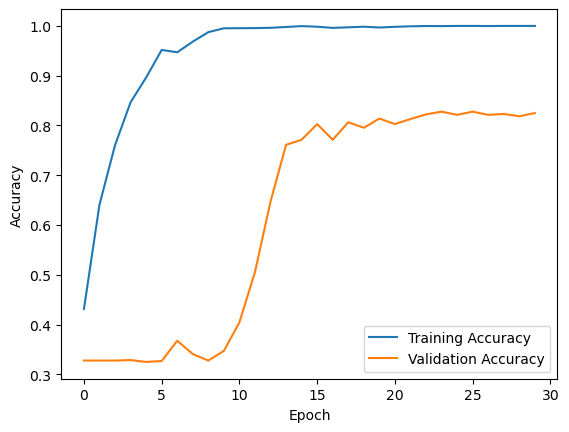

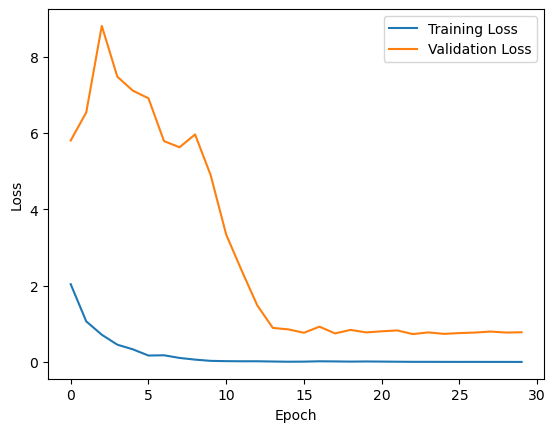

In [19]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The result of the improvement model are also still overfit but `Train` and `Validation` increase so that it is better than the baseline model even though the model can arguqbly only remember, with a Train 1 and Validation 0.82. But the `Loss` in this improvement model is good because the results of the line move in the right direction, it shows that the model learns properly

# 8. Model Predict

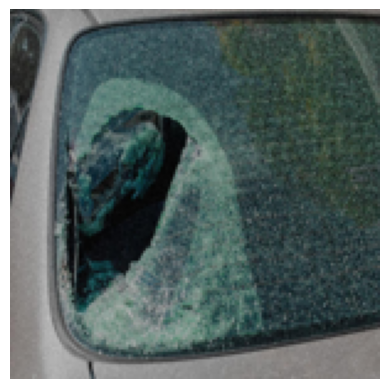

1/1 [==============================] - 0s 24ms/step
Predicted Class: [2]


In [50]:
# Load the image
image_path = 'D:/Hacktiv8/Phase_2/GC7/p2-ftds002-sby-g7-ejayadipraja99/test_image/7615.jpg'
image = Image.open(image_path)

# Preprocess the image
image_size = (150, 150)
image = image.resize(image_size)

# Convert image to a numpy array
image_array = np.array(image)

# Normalize the image data if needed
image_array = image_array / 255.0

# Expand dimensions to create a batch of size 1
image_array = np.expand_dims(image_array, axis=0)

# Display the image
plt.imshow(image_array[0])
plt.axis('off')  # Hide axes
plt.show()

# Predict
predict = improved_model.predict(image_array)

# Get predicted class
predicted_class = np.argmax(predict, axis=1)

print("Predicted Class:", predicted_class)


Predicted `Scratch`, it should be `Glass Shatter`

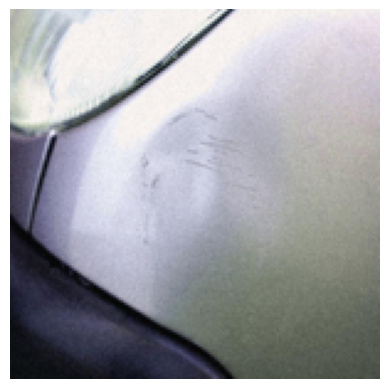

1/1 [==============================] - 0s 22ms/step
Predicted Class: [4]


In [51]:
# Load the image
image_path = 'D:/Hacktiv8/Phase_2/GC7/p2-ftds002-sby-g7-ejayadipraja99/test_image/7616.jpg'
image = Image.open(image_path)

# Preprocess the image
image_size = (150, 150)
image = image.resize(image_size)

# Convert image to a numpy array
image_array = np.array(image)

# Normalize the image data if needed
image_array = image_array / 255.0

# Expand dimensions to create a batch of size 1
image_array = np.expand_dims(image_array, axis=0)

# Display the image
plt.imshow(image_array[0])
plt.axis('off')  # Hide axes
plt.show()

# Predict
predict = improved_model.predict(image_array)

# Get predicted class
predicted_class = np.argmax(predict, axis=1)

print("Predicted Class:", predicted_class)


Predicted `Dent`, it is correct

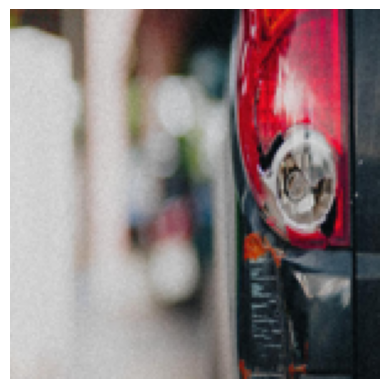

1/1 [==============================] - 0s 23ms/step
Predicted Class: [4]


In [52]:
# Load the image
image_path = 'D:/Hacktiv8/Phase_2/GC7/p2-ftds002-sby-g7-ejayadipraja99/test_image/7617.jpg'
image = Image.open(image_path)

# Preprocess the image
image_size = (150, 150)
image = image.resize(image_size)

# Convert image to a numpy array
image_array = np.array(image)

# Normalize the image data if needed
image_array = image_array / 255.0

# Expand dimensions to create a batch of size 1
image_array = np.expand_dims(image_array, axis=0)

# Display the image
plt.imshow(image_array[0])
plt.axis('off')  # Hide axes
plt.show()

# Predict
predict = improved_model.predict(image_array)

# Get predicted class
predicted_class = np.argmax(predict, axis=1)

print("Predicted Class:", predicted_class)


Predicted `Dent`, it should be `Lamp Broken`

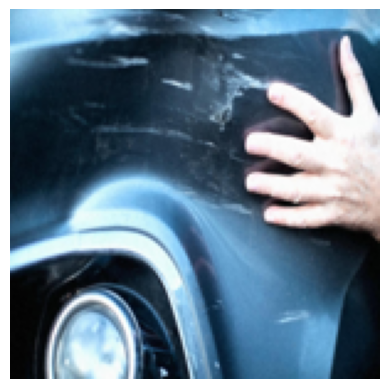

1/1 [==============================] - 0s 24ms/step
Predicted Class: [3]


In [53]:
# Load the image
image_path = 'D:/Hacktiv8/Phase_2/GC7/p2-ftds002-sby-g7-ejayadipraja99/test_image/7618.jpg'
image = Image.open(image_path)

# Preprocess the image
image_size = (150, 150)
image = image.resize(image_size)

# Convert image to a numpy array
image_array = np.array(image)

# Normalize the image data if needed
image_array = image_array / 255.0

# Expand dimensions to create a batch of size 1
image_array = np.expand_dims(image_array, axis=0)

# Display the image
plt.imshow(image_array[0])
plt.axis('off')  # Hide axes
plt.show()

# Predict
predict = improved_model.predict(image_array)

# Get predicted class
predicted_class = np.argmax(predict, axis=1)

print("Predicted Class:", predicted_class)

Predicted `Tire Flat`, it should be `Dent`

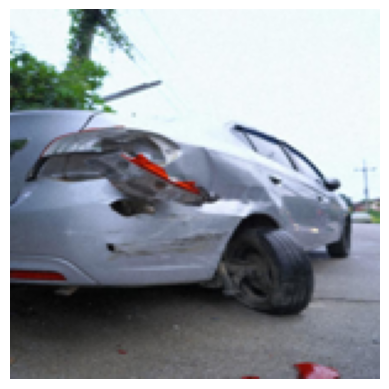

1/1 [==============================] - 0s 25ms/step
Predicted Class: [1]


In [54]:
# Load the image
image_path = 'D:/Hacktiv8/Phase_2/GC7/p2-ftds002-sby-g7-ejayadipraja99/test_image/7619.jpg'
image = Image.open(image_path)

# Preprocess the image
image_size = (150, 150)
image = image.resize(image_size)

# Convert image to a numpy array
image_array = np.array(image)

# Normalize the image data if needed
image_array = image_array / 255.0

# Expand dimensions to create a batch of size 1
image_array = np.expand_dims(image_array, axis=0)

# Display the image
plt.imshow(image_array[0])
plt.axis('off')  # Hide axes
plt.show()

# Predict
predict = improved_model.predict(image_array)

# Get predicted class
predicted_class = np.argmax(predict, axis=1)

print("Predicted Class:", predicted_class)


Predicted `Crack`, it is correct

From 5 model classification prediction only 2 out of 5 were successfully classified correctly

# 10. Model Saving

Model saving happens during the model training.

# 11. Model Inference

Model inference is in the folder `inference` with file name `P2G7_erlangga_jayadipraja_inference.ipynb`

# 12. Conclusion

- From EDA we can conclude that the dataset is very unbalance, it makes the model can't learn properly. From the baseline model and the model Improvement we can see that there are improvements between the baseline model and the improvement model, althought the result is still overfit. It causes the results of the classification prediction only correct 2 out if 5 on the prediction test.

- Therefore, for further improvement can create more balanced dataset, and also can add an image augmentation and look for better model parameters in order to get the best result of the model so the model can be used in the real case scenarios.